**This notebook will become qmd in the future. For now, it is a jupyter notebook.**

ideas for introduction to AB slide or maybe earlier slides:
- talk about prior predictive check
- Beta prior <--> Binomial likelihood
    - we observe some people converted in A and B (likelihood)
    - We want to learn more about conversion probability theta.
    - Hence we need Beta prior for theta
- introduce HDI




In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm

In [3]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=8,
)

# Two Variants A, B
## Bernoulli conversion
### PART I: there's no data yet, let's check the prior

In [14]:
# let's define the variants A and B, and the number of trials and successes
variants  = ['A', 'B']

# each variant has one trail 
trials    = [1000, 1000]

# the only trial leads to success
successes = [200, 200]

# let's define parameters for a weak prior for the conversion rates
weak_alpha, weak_beta = [100, 100]

The model has four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior (or just checking the prior)

In [15]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift_B", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=10, return_inferencedata=False)

Only 10 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 22 seconds.
The number of samples is too small to check convergence reliably.


Unobserved Random Variables:

Note that theta is the name of the unobserved RV, and then parameter keyword arguments e.g. alpha are followed

In [6]:
example_model.unobserved_RVs    

[theta ~ Beta(100, 100), uplift_B ~ Deterministic(f(theta))]

Observed Random Variables:

Similar to the unobserved RVs but require data to be passed into the **observed** keyword argument:

In [7]:
example_model.observed_RVs    

[y ~ Binomial(<constant>, theta)]

In [ ]:
example_model.basic_RVs

[theta, y]

In [ ]:
example_model.free_RVs

[theta]

In [8]:
trace

<MultiTrace: 4 chains, 10 iterations, 3 variables>

In [11]:
trace.theta.shape,  trace.uplift_B.shape

((40, 2), (40,))

In [ ]:
# let's create a dataframe with the output of the prior predictive
weak_outcome = pd.concat([pd.DataFrame(trace['theta']), 
                          pd.DataFrame(trace['uplift_B'])],
                          axis=1)

weak_outcome.columns = ['theta_A','theta_B','uplift_B']
weak_outcome.head(3)

,theta_A,theta_B,uplift_B
0,0.258791,0.263571,0.018472
1,0.245809,0.231719,-0.057320
2,0.249201,0.267733,0.074364


In [ ]:
# let's check the summary statistics of the output of the prior predictive
weak_outcome.describe()

,theta_A,theta_B,uplift_B
count,40.000000,40.000000,40.000000
mean,0.249754,0.249867,0.002964
std,0.011634,0.012216,0.073874
min,0.222039,0.220463,-0.152144
25%,0.243951,0.243662,-0.038572
50%,0.249044,0.249373,-0.014287
75%,0.257862,0.258701,0.039247
max,0.271676,0.274071,0.162102


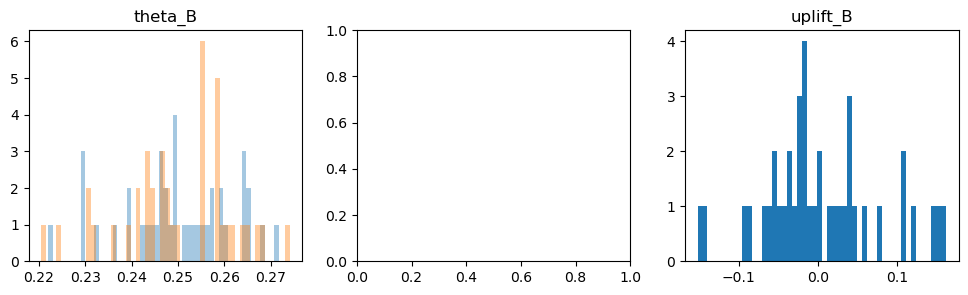

In [ ]:
# let's create a  subplot with three plots in a row that shows the theta_A, theta_B and uplift_B
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# plot the distribution of theta_A
ax[0].hist(weak_outcome['theta_A'],bins=50, alpha=0.4)
ax[0].set_title('theta_A')

# plot the distribution of theta_B
ax[1].hist(weak_outcome['theta_B'],bins=50, alpha=0.4)
ax[1].set_title('theta_B')

# plot the distribution of uplift_B
ax[2].hist(weak_outcome['uplift_B'], bins=50)
ax[2].set_title('uplift_B')

plt.show()


In [ ]:
# return_inferencedata=True

In [ ]:
pm.summary(trace, var_names=["theta", "uplift_B"]).T

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace

we can also use the ArviZ library for plotting. The main advantage is that it works pretty well with the output data. Also, it gives the HDI for the Relative Uplift distribution.

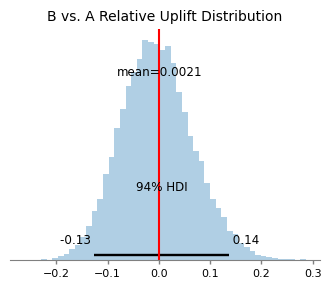

In [ ]:
az.plot_posterior(trace["uplift_B"], **plotting_defaults, figsize=(4, 3))

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

How we choose these priors in practice depends on broader context of the company running the A/B tests. 

- A strong prior can help guard against false discoveries, but may **require more data** to detect winning variants when they exist (and more data = more time required running the test). 
- A weak prior gives **more weight to the observed data**, but could also lead to more false discoveries as a result of early stopping issues.

### PART II: still no data yet, let's check the posterior

In [16]:
with pm.Model() as model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift_B", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the posterior
    trace = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [ ]:
# Each row of an array is treated as an independent series of draws from the variable, called a chain.
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
# as an example, for theta we have 4 chains, each with 5000 draws. The last value 2 refers to the theta_A and theta_B. So for theta_A we have 4 chains, each with 5000 draws.
# and same for theta_B.
trace.posterior.theta.shape

(4, 5000, 2)

In [ ]:
# similarly for the relative uplift we have 4 chains, each with 5000 draws.
trace.posterior.uplift_B.shape

(4, 5000)

In [17]:
pm.summary(trace, var_names=["theta", "uplift_B"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.250,0.012,0.225,0.272,0.000,0.000,4111.0,3219.0,1.0
theta[1],0.250,0.012,0.225,0.272,0.000,0.000,3999.0,3283.0,1.0
uplift_B,0.003,0.070,-0.119,0.138,0.001,0.001,3973.0,2679.0,1.0


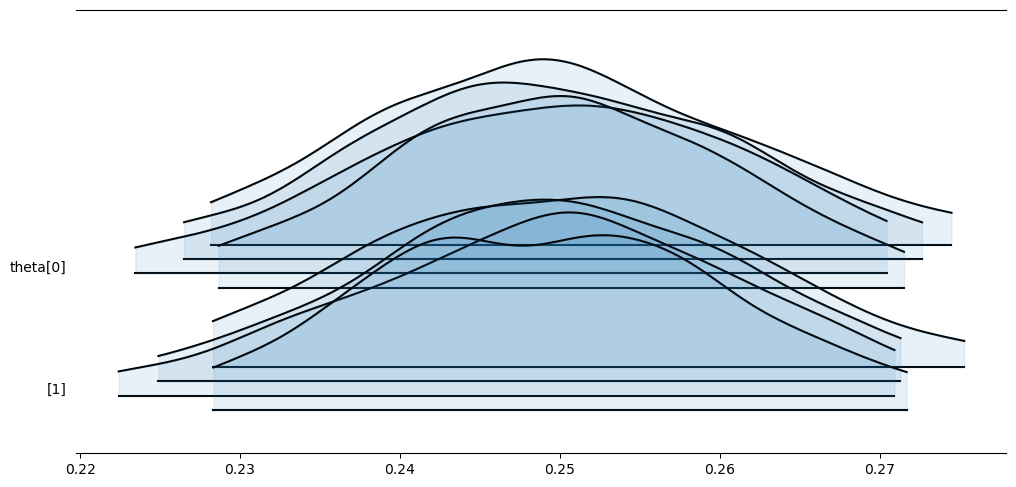

In [18]:
az.plot_forest(trace, var_names=["theta"], combined=False, kind="ridgeplot", ridgeplot_alpha=0.1);

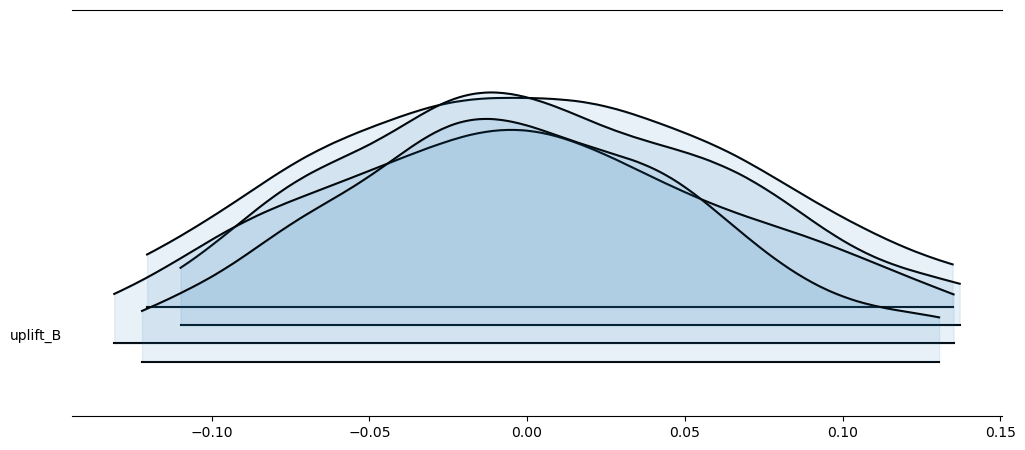

In [19]:
az.plot_forest(trace, var_names=["uplift_B"], combined=False, kind="ridgeplot", ridgeplot_alpha=0.1);

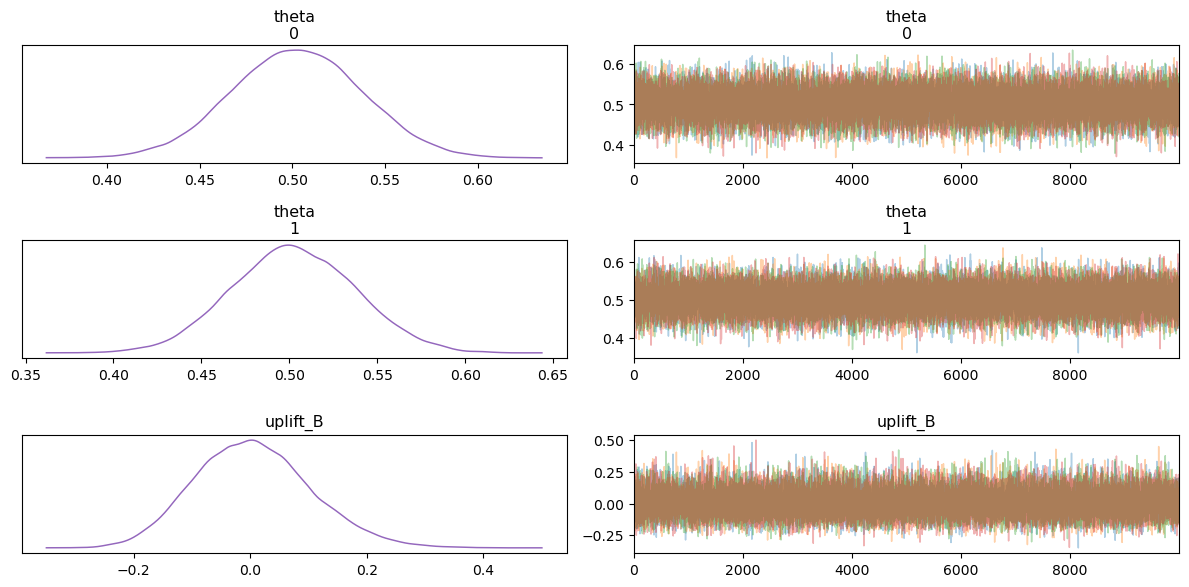

In [ ]:
az.plot_trace(trace, compact=False, combined=True)
plt.tight_layout();

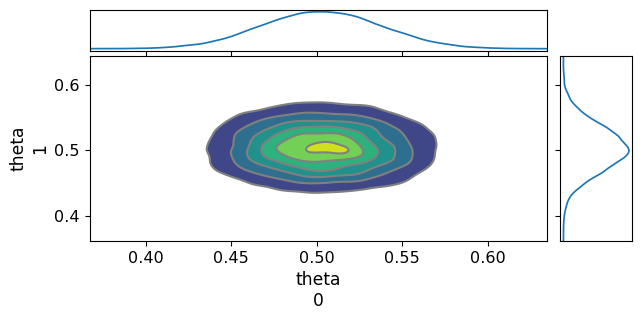

In [ ]:
az.plot_pair(trace, var_names=["theta"], kind="kde", marginals=True, figsize=(7, 3));

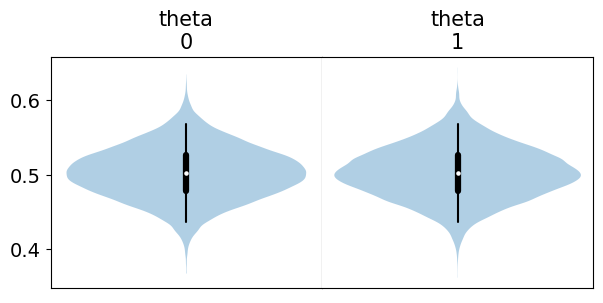

In [ ]:
az.plot_violin(trace, var_names=["theta"], figsize=(7, 3));

these codes and plots become slides and you explain them with the text stored in notes.md. During the hands-on they try with simulated data from bernoulli distribution.

Day02-2 will be only hands-on, where they learn about **value conversion**.
Day02-3-4 will be the same but with their own data.